In [4]:
%matplotlib inline

%cd '/jetfs/home/a12233665/pai-munich-vienna/'
import sys
sys.path.append('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/')
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import numpy as np
from datetime import datetime
from joblib import Parallel, delayed
from numba import njit
import xarray as xr
from pathlib import Path
import gc
import cProfile, pstats, io
from pstats import SortKey
import time

from kendapy.ekf import Ekf
from enstools.io import read, write

import pai.observation as oi
from pai.observation import Observation
#import pai.localization as loc
from pai.localization import get_dist_from_obs, gaspari_cohn, vertical_dist, haversine_distance
import pai.pai_utils as paiut
from pai.pai_utils import get_failure_list
import Plotting.Plot_Functions as pf

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import cProfile, pstats

import os

from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

/jetfs/home/a12233665/pai-munich-vienna


In [5]:
def read_grib(path, vars, grid_path="/jetfs/home/a12233665/pai-munich-vienna/assets/icon_grid_0047_R19B07_L.nc"):

    #Reads a grib file and assigns it standard lat/lon coordinates based on the grid file.
    data = read(path)#.rename(values="cell")
    data = data[[*vars, 'pres']]
    grid = xr.open_dataset(grid_path)

    data = data.assign_coords(clat=("cell", grid.clat.values * 180 / np.pi))
    data = data.assign_coords(clon=("cell", grid.clon.values * 180 / np.pi))

    return data

In [6]:
def get_ekf(ekf_path, obsvar, llon = None, rlon = None, llat = None, ulat = None, whole_domain = True):
    ekf = Ekf(ekf_path, filter=f"state=active")
    ekf.add_filter(filter=f"varname={obsvar}")
    if whole_domain == False:
        location = produce_DWD_rectangle(llon, rlon, llat, ulat)
        print(location)
        ekf.add_filter(filter=f"{location}")
    return ekf

In [8]:
def sort_cloud_on_off2(ana_days, exp_path, obspres_list, vloc_list, errors_location, errors_suffix, no_obs_error_location, failure_list, optvar = 'RAWBT', cloudvar = 'REFL', first_RAWBT = False, threshold = 0.4):
    np.random.seed(20)
    Global_Errs_Clouds = np.zeros((2, 4, len(obspres_list), len(vloc_list))) #Store the sums of all the errors here
    Global_Errs_Clouds_Halfs = np.zeros((2, 2, 4, len(obspres_list), len(vloc_list))) #Store the sums of all the errors here
    inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')
    inf_ds_full = inf_ds_full.load()
    if cloudvar == 'REFL':
        inf_ds_var = 'REFL_value'
    elif first_RAWBT:
        inf_ds_var = 'RAWBT_mean1'
    else:
        inf_ds_var = 'RAWBT_mean2'
    h_loc = 25
    obspres_num = len(obspres_list)
    vloc_num = len(vloc_list)
    Global_Errs = np.zeros((4, obspres_num, vloc_num))
    Global_Errs_Halfs = np.zeros((2, 4, obspres_num, vloc_num))
    no_obs_err_total = np.zeros((2))
    no_obs_err_onoff = np.zeros((2, 2))
    no_obs_err_halfs = np.zeros((2, 2))
    no_obs_err_halfs_onoff = np.zeros((2, 2, 2))
    
    for j, vloc in enumerate(vloc_list):
        for k, obspres in enumerate(obspres_list):
            Global_Errs_Clouds[0, 0, k, j] = vloc
            Global_Errs_Clouds[1, 0, k, j] = vloc
            Global_Errs_Clouds[0, 1, k, j] = obspres
            Global_Errs_Clouds[0, 1, k, j] = obspres
            Global_Errs[0, k, j] = vloc
            Global_Errs[1, k, j] = obspres
    cat_1_num = 0
    cat_2_num = 0
    for ind, ana_day in enumerate(ana_days):
        if ana_day == '20230601':
            if optvar == 'RAWBT':
                Times = [6, 12]
            else:
                Times = [6, 9, 12, 15]
        else:
            if optvar == 'RAWBT':
                Times = [0, 6, 12]
            else:
                Times = [6, 9, 12, 15]
        for Time in Times:
            if Time == 0:
                ana_time = ana_day + '000000'
                dir_time_sonde = ana_days[ind - 1] + '210000'
                sonde_time = ana_days[ind - 1] + '230000'
            elif Time == 6:
                ana_time = ana_day + '060000'
                dir_time_sonde = ana_day + '030000'
                sonde_time = ana_day + '050000'
            elif Time == 9:
                ana_time = ana_day + '090000'
                dir_time_sonde = ana_day + '060000'
                sonde_time = ana_day + '080000'
            elif Time == 12:
                ana_time = ana_day + '120000'
                dir_time_sonde = ana_day + '090000'
                sonde_time = ana_day + '110000'
            else:
                ana_time = ana_day + '150000'
                dir_time_sonde = ana_day + '120000'
                sonde_time = ana_day + '140000'
            #dir_time_sonde = ana_day + '090000'  # directory
            #sonde_time = ana_day + '110000'   # time of verifying radiosonde observations
            #ana_time = ana_day + '120000'  # analysis time of first guess forecasts
            no_obs_err_list = np.load(no_obs_error_location + ana_time + '.npy', allow_pickle = True)
            print(ana_time)
            obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time_sonde, sonde_time)
            obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
            ekf_TEMP1 = paiut.get_ekf(obs_path_TEMP1, 'RH', active = False)
            if os.path.isfile(obs_path_TEMP2) == True:
                ekf_TEMP2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                report_number = len(ekf_TEMP1.reports()) + len(ekf_TEMP2.reports())
            else:
                report_number = len(ekf_TEMP1.reports())
            err = [np.array(Errors) for Errors in np.load(errors_location + ana_time + errors_suffix + ".npy", allow_pickle = True)]
            no_obs_err_counter = 0
            cat_1_len = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full[inf_ds_var] > threshold), drop = True)[inf_ds_var].shape[0]
            cat_2_len = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full[inf_ds_var] <= threshold), drop = True)[inf_ds_var].shape[0]
            # Create an array of zeros with the total size
            mask1 = np.zeros(cat_1_len)
            mask2 = np.zeros(cat_2_len)
            # Randomly choose indices for the subsample
            subsample_indices1 = np.random.choice(cat_1_len, size=cat_1_len // 2, replace=False)
            subsample_indices2 = np.random.choice(cat_2_len, size=cat_2_len // 2, replace=False)
            # Set the chosen indices to one
            mask1[subsample_indices1] = 1
            mask2[subsample_indices2] = 1
            print(sum(mask1), sum(mask2), cat_1_len, cat_2_len)
            cat_1_counter = 0
            cat_2_counter = 0
            #print(mask1, mask2, mask1[cat_1_counter], mask2[cat_2_counter])
            print(len(ekf_TEMP1.reports()), len(ekf_TEMP2.reports()))
            for i in range(report_number):
                if np.array(err[i]).shape[0] == 0:
                    print('no errors')
                    continue
                print(i)
                if np.isnan(np.array(err[i])[0, 3]):
                    print('SCHEISSE! NAN!' + ana_day + str(rep))
                    no_obs_err_counter += 1
                    continue
                print(inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)[inf_ds_var].values[0])
                if inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)[inf_ds_var].values[0] > threshold:#As always 2 IR obs stored. Say cloudy if less than value, so the second one is cloudy.
                    cat_1_num += 1
                    half_choice = int(mask1[cat_1_counter])
                    for j, vloc in enumerate(vloc_list):
                        for k, obspres in enumerate(obspres_list):
                            Global_Errs[2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs[3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                            Global_Errs_Halfs[half_choice, 2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs_Halfs[half_choice, 3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                            Global_Errs_Clouds[0, 2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs_Clouds[0, 3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                            Global_Errs_Clouds_Halfs[half_choice, 0, 2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs_Clouds_Halfs[half_choice, 0, 3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                    no_obs_err_total[0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_total[1] += float(no_obs_err_list[no_obs_err_counter][3])
                    no_obs_err_halfs[half_choice, 0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_halfs[half_choice, 1] += float(no_obs_err_list[no_obs_err_counter][3])
                    no_obs_err_onoff[0, 0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_onoff[0, 1] += float(no_obs_err_list[no_obs_err_counter][3])
                    no_obs_err_halfs_onoff[half_choice, 0, 0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_halfs_onoff[half_choice, 0, 1] += float(no_obs_err_list[no_obs_err_counter][3])
                    cat_1_counter += 1
                else:
                    cat_2_num += 1
                    half_choice = int(mask2[cat_2_counter])
                    for j, vloc in enumerate(vloc_list):
                        for k, obspres in enumerate(obspres_list):
                            Global_Errs[2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs[3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                            Global_Errs_Halfs[half_choice, 2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs_Halfs[half_choice, 3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                            Global_Errs_Clouds[1, 2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs_Clouds[1, 3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                            Global_Errs_Clouds_Halfs[half_choice, 1, 2, k, j] += np.array(err[i])[j*obspres_num + k, 2]
                            Global_Errs_Clouds_Halfs[half_choice, 1, 3, k, j] += np.array(err[i])[j*obspres_num + k, 3]
                    no_obs_err_total[0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_total[1] += float(no_obs_err_list[no_obs_err_counter][3])
                    no_obs_err_halfs[half_choice, 0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_halfs[half_choice, 1] += float(no_obs_err_list[no_obs_err_counter][3])
                    no_obs_err_onoff[1, 0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_onoff[1, 1] += float(no_obs_err_list[no_obs_err_counter][3])
                    no_obs_err_halfs_onoff[half_choice, 1, 0] += float(no_obs_err_list[no_obs_err_counter][2])
                    no_obs_err_halfs_onoff[half_choice, 1, 1] += float(no_obs_err_list[no_obs_err_counter][3])
                    #print(no_obs_err_halfs[cat_2_num % 2, :], Global_Errs_Halfs[cat_2_num % 2, :, 6, 0])
                    cat_2_counter += 1
                no_obs_err_counter += 1
                #print(Global_Errs.shape, Global_Errs_Clouds.shape)
        print(cat_1_num, cat_2_num)
        #print(Global_Errs.shape, Global_Errs_Clouds.shape)
    return Global_Errs, Global_Errs_Halfs, Global_Errs_Clouds, Global_Errs_Clouds_Halfs, no_obs_err_total, no_obs_err_onoff, no_obs_err_halfs, no_obs_err_halfs_onoff

In [15]:
def plot_sensitivity_cloud_contour_together(Errs, Errs_Halfs, Errs_Clouds, Errs_Clouds_Halfs, save_name, verticals, widths,  use_no_obs_err = False, no_obs_err = np.zeros((2, 2)), no_obs_err_half = np.zeros((2, 2)), no_obs_err_clouds = np.zeros((2, 2)), no_obs_err_clouds_halfs = np.zeros((2, 2)), cat_1_name = 'Cloudy', cat_2_name = 'Clear', half_1_name='Sample 1', half_2_name = 'Sample 2', Title = 'Sensitivity Plot', save = True):
    vloc_num = len(widths)
    obspres_num = len(verticals)
    label_size = 40
    VLOC, OBSPRES= np.meshgrid(widths, np.array(verticals)/100)
    if use_no_obs_err:
        Errs_proportion1 = (Errs[2, :, :] / float(no_obs_err[0]) ) - 1
        Errs_proportion_clouds = np.zeros((Errs_Clouds.shape[0], Errs_Clouds.shape[2], Errs_Clouds.shape[3]))
        Errs_proportion_clouds[0, :, :] = (Errs_Clouds[0, 2, :, :] / float(no_obs_err_clouds[0, 0])) - 1
        Errs_proportion_clouds[1, :, :] = (Errs_Clouds[1, 2, :, :] / float(no_obs_err_clouds[1, 0])) - 1
    else:
        Errs_proportion1 = Errs[2, :, :]
        Errs_proportion_clouds = Errs_Clouds[:, 2, :, :]
    max_dif = max(np.abs(Errs_proportion1.min()), np.abs(Errs_proportion1.max()), np.abs(Errs_proportion_clouds.min()), np.abs(Errs_proportion_clouds.max()))
    #norm = mcolors.TwoSlopeNorm(vmin=min(-max_dif, -0.000001),
    #                            vcenter=0, 
    #                            vmax=max(max_dif, 0.000001))
    #norm = mcolors.TwoSlopeNorm(vmin = -0.0045,
    #                            vcenter=0, 
    #                            vmax = 0.0045)
    #norm = mcolors.TwoSlopeNorm(vmin=min(Errs_proportion1.min(), Errs_proportion_clouds.min(), -0.000001),
    #                            vcenter=0, 
    #                            vmax=max(Errs_proportion1.max(), Errs_proportion_clouds.max(), 0.000001))
    levels = MaxNLocator(nbins=25).tick_vimport string
    cmap = plt.colormaps['PiYG']
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)                        
    fig, axs = plt.subplots(1, 3, figsize = (21, 7))
    fig.tight_layout()
    for i, Errs_proportion in enumerate([Errs_proportion1, Errs_proportion_clouds[0, :, :], Errs_proportion_clouds[1, :, :]]):
        #CS = axs.contourf(VLOC, OBSPRES, Errs_proportion, levels = 20, norm = norm, cmap = 'BrBG_r')
        #if i == 2:
        #    cbar = fig.colorbar(CS)
        #    cbar.set_label('Combined Error J as Proportion \n of \'no obs error\'', fontsize = 15)
            #cbar.set_clim(min(Errs_proportion1.min(), Errs_proportion_clouds.min()), max(Errs_proportion1.max(), Errs_proportion_clouds.max()))
            #colorbar.set_ticks([-1, 0, 1])
        min_err = Errs_proportion.min()
        max_err = Errs_proportion.max()
        if use_no_obs_err:
            err_obs_removed = [float(no_obs_err[0]), float(no_obs_err_clouds[0, 0]), float(no_obs_err_clouds[1, 0])][i]
            #norm = mcolors.TwoSlopeNorm(vmin=min(min_err, err_obs_removed - 0.0001),
            #                            vcenter= err_obs_removed, 
            #                            vmax=max(max_err, err_obs_removed + 0.0001))
        #norm = mcolors.TwoSlopeNorm(vmin=min(min_err, 0.9999),
        #                            vcenter=1, 
        #                            vmax=max(max_err, 1.00001))
        #CS = axs.contourf(VLOC, OBSPRES, Errs_proportion, levels = 20, norm = norm, cmap = 'BrBG_r')
        CS = axs[i].pcolormesh(VLOC, OBSPRES, Errs_proportion, cmap = 'PiYG_r', norm = norm)#levels = 20, norm = norm, cmap = 'BrBG_r')
        if i == 2:
            cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(CS, cax = cbar_ax)
            cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 1))
            cbar.set_label('Estimated change in\npercentage error', fontsize = label_size - 1)
            cbar.ax.axhline(err_obs_removed, c='k')
            cbar.ax.tick_params(labelsize=label_size - 5)
        axs[i].set_title(Title + [' full sample', cat_1_name, cat_2_name][i], fontsize = label_size + 1)
        axs[i].set_xlabel('Width [log(hPa)]', fontsize = label_size - 1)
        if i == 0:
            axs[i].set_ylabel('Vertical Location [hPa]', fontsize = label_size - 1)
        else:
            axs[i].tick_params(left = False, labelleft = False)
        axs[i].tick_params(labelsize = label_size - 5)
        axs[i].invert_yaxis()
    plt.subplots_adjust(left=0.03,
                        bottom=0.03, 
                        right=0.97, 
                        top = 0.95,
                        wspace=0.1, 
                        hspace=0.1)
    if save == True:
        plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + save_name + '.png', bbox_inches='tight')

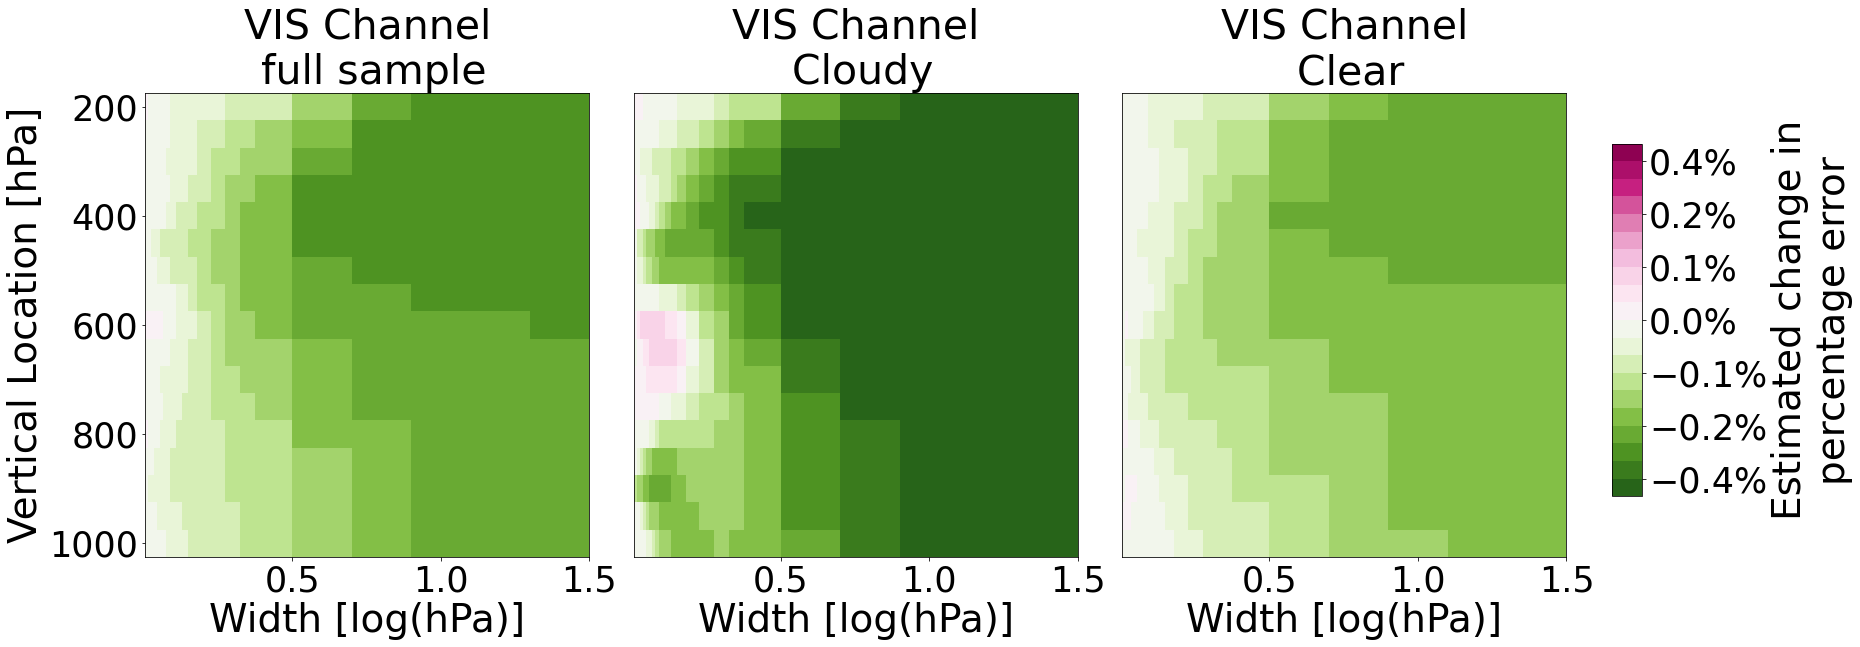

In [55]:
G_errs_test, G_errs_halfs_test, G_errs_clouds_test, G_errs_clouds_halfs_test, G_errs_no_obs_test, G_errs_no_obs_halfs_test, G_errs_no_obs_clouds_test, G_errs_no_obs_clouds_halfs_test = global_from_T_RH(Global_Errs2, 
                                                                                                                                                                                                            Global_Errs_Halfs2, 
                                                                                                                                                                                                            Global_Errs_Clouds2, 
                                                                                                                                                                                                            Global_Errs_Clouds_Halfs2, 
                                                                                                                                                                                                            no_obs_err_total2, 
                                                                                                                                                                                                            no_obs_err_halfs2, 
                                                                                                                                                                                                            no_obs_err_onoff2, 
                                                                                                                                                                                                            no_obs_err_halfs_onoff2,
                                                                                                                                                                                                            just_T = False)
plot_sensitivity_cloud_contour_together(G_errs_test, G_errs_halfs_test, G_errs_clouds_test, G_errs_clouds_halfs_test,
                                'New_VIS_Cloudonoff', obspres_list, vloc_list,  use_no_obs_err = True, 
                                no_obs_err = G_errs_no_obs_test, no_obs_err_half = G_errs_no_obs_halfs_test, 
                                no_obs_err_clouds = G_errs_no_obs_clouds_test, 
                                no_obs_err_clouds_halfs = G_errs_no_obs_clouds_halfs_test, 
                                cat_1_name = ' Cloudy', cat_2_name = ' Clear', 
                                half_1_name=' Cloudy', half_2_name = ' Clear', 
                                Title = 'VIS Channel\n', save = True)

In [71]:
import string
from itertools import cycle
from six.moves import zip
def label_axes_abcd(axs, labels=None, loc=None, **kwargs):
    """
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase
    
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (.9, .9)
    for ax, lab in zip(axs, labels):
        ax.annotate(lab, xy=loc,
                    xycoords='axes fraction',
                    fontsize=50,
                    **kwargs)

In [84]:
def plot_two_row(Errs1, Errs2, save_name, verticals, widths, use_no_obs_err = True, no_obs_err1 = 0, no_obs_err2 = 0, cat_1_name = ' Temperature', cat_2_name = ' Relative Humidity', Title = 'Error', save = True):
    vloc_num = len(widths)
    obspres_num = len(verticals)
    label_size = 35
    VLOC, OBSPRES= np.meshgrid(widths, np.array(verticals)/100)
    if use_no_obs_err:
        Errs_proportion1 = (Errs1 / float(no_obs_err1) ) - 1
        Errs_proportion2 = (Errs2 / float(no_obs_err2) ) - 1
    else:
        Errs_proportion1 = Errs1
        Errs_proportion2 = Errs2
    #max_dif = max(np.abs(Errs_proportion1.min()), np.abs(Errs_proportion1.max()), np.abs(Errs_proportion_clouds.min()), np.abs(Errs_proportion_clouds.max()))
    #norm = mcolors.TwoSlopeNorm(vmin=min(-max_dif, -0.000001),
    #                            vcenter=0, 
    #                            vmax=max(max_dif, 0.000001))
    #norm = mcolors.TwoSlopeNorm(vmin = -0.0045,
    #                            vcenter=0, 
    #                            vmax = 0.0045)
    #norm = mcolors.TwoSlopeNorm(vmin=min(Errs_proportion1.min(), Errs_proportion_clouds.min(), -0.000001),
    #                            vcenter=0, 
    #                            vmax=max(Errs_proportion1.max(), Errs_proportion_clouds.max(), 0.000001))
    levels = MaxNLocator(nbins=18).tick_values(-0.004, 0.004)
    cmap = plt.colormaps['PiYG']
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)                        
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.tight_layout()
    for i, Errs_proportion in enumerate([Errs_proportion1, Errs_proportion2]):
        #CS = axs.contourf(VLOC, OBSPRES, Errs_proportion, levels = 20, norm = norm, cmap = 'BrBG_r')
        #if i == 2:
        #    cbar = fig.colorbar(CS)
        #    cbar.set_label('Combined Error J as Proportion \n of \'no obs error\'', fontsize = 15)
            #cbar.set_clim(min(Errs_proportion1.min(), Errs_proportion_clouds.min()), max(Errs_proportion1.max(), Errs_proportion_clouds.max()))
            #colorbar.set_ticks([-1, 0, 1])
        min_err = Errs_proportion.min()
        max_err = Errs_proportion.max()
        #if use_no_obs_err:
            #err_obs_removed = [float(no_obs_err[0]), float(no_obs_err_clouds[0, 0]), float(no_obs_err_clouds[1, 0])][i]
            #norm = mcolors.TwoSlopeNorm(vmin=min(min_err, err_obs_removed - 0.0001),
            #                            vcenter= err_obs_removed, 
            #                            vmax=max(max_err, err_obs_removed + 0.0001))
        #norm = mcolors.TwoSlopeNorm(vmin=min(min_err, 0.9999),
        #                            vcenter=1, 
        #                            vmax=max(max_err, 1.00001))
        #CS = axs.contourf(VLOC, OBSPRES, Errs_proportion, levels = 20, norm = norm, cmap = 'BrBG_r')
        CS = axs[i].pcolormesh(VLOC, OBSPRES, Errs_proportion, cmap = 'PiYG_r', norm = norm)#levels = 20, norm = norm, cmap = 'BrBG_r')
        if i == 0:
            cbar_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
            cbar = fig.colorbar(CS, cax = cbar_ax)
            cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 1))
            cbar.set_label('$\\Delta$J$(\\rho)\\%$', fontsize = label_size - 1)
            #cbar.ax.axhline(err_obs_removed, c='k')
            cbar.ax.tick_params(labelsize=label_size - 5)
            axs[i].set_ylabel('Vertical Location [hPa]', fontsize = label_size - 1)
        else:
            axs[i].tick_params(left = False, labelleft = False)
        axs[i].set_title(Title + [cat_1_name, cat_2_name][i], fontsize = label_size + 1)
        #if i == 0:
        axs[i].set_xlabel('Width [log(hPa)]', fontsize = label_size - 1)
        
        axs[i].tick_params(labelsize = label_size - 3)
        axs[i].invert_yaxis()
    plt.subplots_adjust(left=0.03,
                        bottom=0.03, 
                        right=0.97, 
                        top = 0.95,
                        wspace=0.1, 
                        hspace=0.2)
    label_axes_abcd(axs, loc=(0.45, 1.25), labels=['(a)', '(b)', '(c)'])
    if save == True:
        plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + save_name + '.png', bbox_inches='tight')

In [79]:
def plot_three_row(Errs1, Errs2, Errs3, save_name, verticals, widths, use_no_obs_err = True, no_obs_err1 = 0, no_obs_err2 = 0, no_obs_err3 = 0, cat_1_name = ' VIS 0.6', cat_2_name = ' IR 6.2', cat_3_name = 'IR 7.3', Title = 'Error', save = True):
    vloc_num = len(widths)
    obspres_num = len(verticals)
    label_size = 35
    VLOC, OBSPRES= np.meshgrid(widths, np.array(verticals)/100)
    if use_no_obs_err:
        Errs_proportion1 = (Errs1 / float(no_obs_err1) ) - 1
        Errs_proportion2 = (Errs2 / float(no_obs_err2) ) - 1
        Errs_proportion3 = (Errs3 / float(no_obs_err3) ) - 1
    else:
        Errs_proportion1 = Errs1
        Errs_proportion2 = Errs2
        Errs_proportion3 = Errs3
    levels = MaxNLocator(nbins=18).tick_values(-0.004, 0.004)
    cmap = plt.colormaps['PiYG']
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)                        
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(22)
    axs = []
    axs.append(plt.subplot2grid(shape=(3, 10), loc=(0, 0), colspan=3, rowspan = 3))
    axs.append(plt.subplot2grid(shape=(3, 10), loc=(0, 3), colspan=3, rowspan = 3))
    axs.append(plt.subplot2grid(shape=(3, 10), loc=(0, 6), colspan=3, rowspan = 3))
    axs.append(plt.subplot2grid(shape=(3, 10), loc=(0, 9), colspan=1, rowspan = 3))
    fig.tight_layout()
    for i, Errs_proportion in enumerate([Errs_proportion1, Errs_proportion2, Errs_proportion3]):
        CS = axs[i].pcolormesh(VLOC, OBSPRES, Errs_proportion, cmap = 'PiYG_r', norm = norm)#levels = 20, norm = norm, cmap = 'BrBG_r')
        if i == 0:
            cbar = fig.colorbar(CS, cax = axs[3])
            cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 1))
            cbar.set_label('$\\Delta$J$(\\rho) \\%$', fontsize = label_size - 1) #'Estimated change in\npercentage error'
            cbar.ax.tick_params(labelsize=label_size - 5)
            axs[i].set_ylabel('Vertical Location [hPa]', fontsize = label_size - 1)
        elif i != 0:
            axs[i].tick_params(left = False, labelleft = False)
        else:
            axs[i].set_ylabel('Vertical Location [hPa]', fontsize = label_size - 1)
        axs[i].set_title(Title + [cat_1_name, cat_2_name, cat_3_name][i], fontsize = label_size + 1)
        #if i == 0:
        axs[i].set_xlabel('Width [log(hPa)]', fontsize = label_size - 1)
        axs[i].tick_params(labelsize = label_size - 3)
        axs[i].invert_yaxis()
    plt.subplots_adjust(left=0.03,
                        bottom=0.03, 
                        right=0.97, 
                        top = 0.95,
                        wspace=0.5, 
                        hspace=1)
    label_axes_abcd(axs[:-1], loc=(0.45, 1.15), labels=['(a)', '(b)', '(c)'])
    if save == True:
        plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + save_name + '.png', bbox_inches='tight')

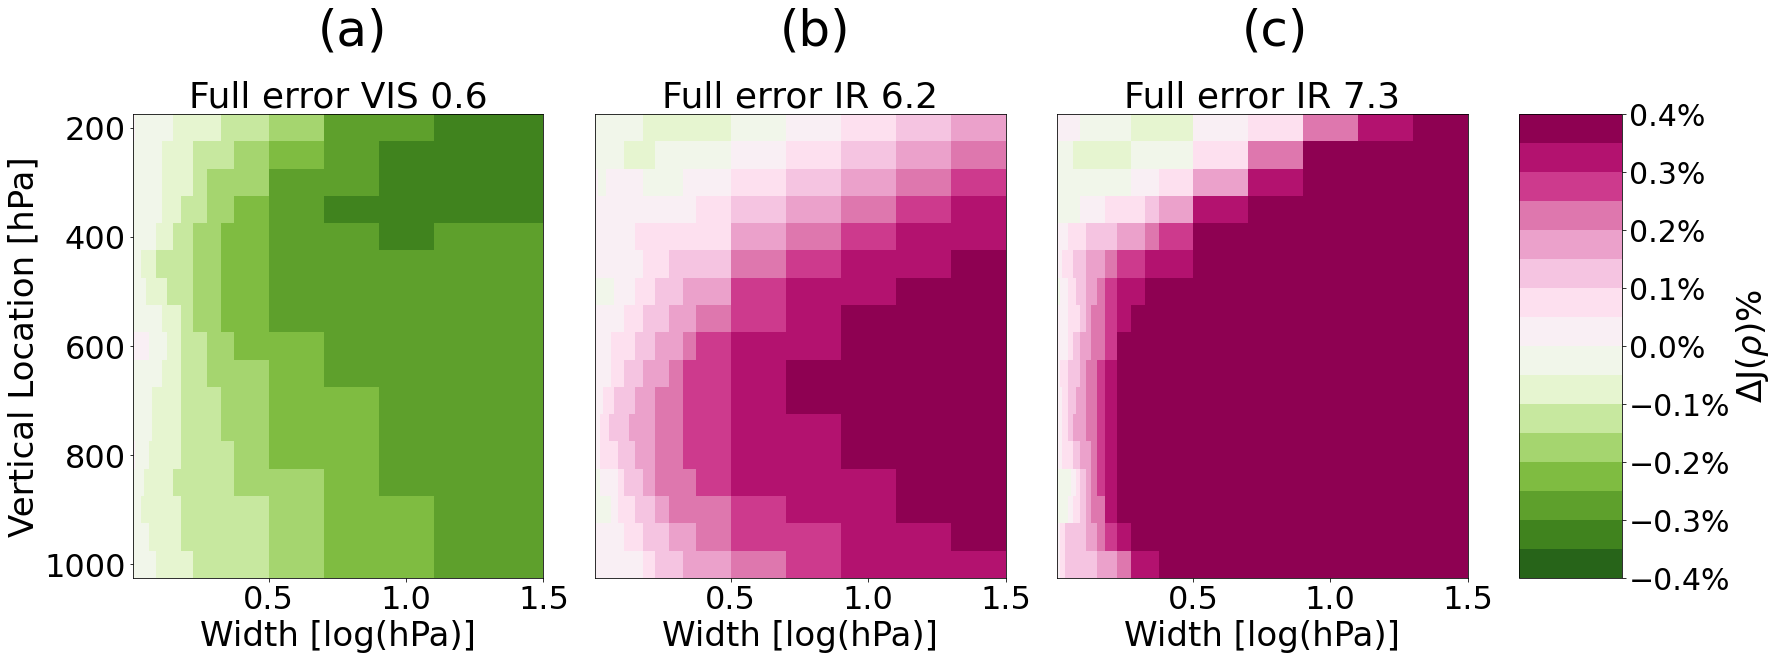

In [80]:
%matplotlib inline
G_errs_test2, G_errs_halfs_test2, G_errs_clouds_test2, G_errs_clouds_halfs_test2, G_errs_no_obs_test2, G_errs_no_obs_halfs_test2, G_errs_no_obs_clouds_test2, G_errs_no_obs_clouds_halfs_test2 = global_from_T_RH(Global_Errs2, 
                                                                                                                                                                                                            Global_Errs_Halfs2, 
                                                                                                                                                                                                            Global_Errs_Clouds2, 
                                                                                                                                                                                                            Global_Errs_Clouds_Halfs2, 
                                                                                                                                                                                                            no_obs_err_total2, 
                                                                                                                                                                                                            no_obs_err_halfs2, 
                                                                                                                                                                                                            no_obs_err_onoff2, 
                                                                                                                                                                                                            no_obs_err_halfs_onoff2,
                                                                                                                                                                                                            just_T = False)
G_errs_test1, G_errs_halfs_test1, G_errs_clouds_test1, G_errs_clouds_halfs_test1, G_errs_no_obs_test1, G_errs_no_obs_halfs_test1, G_errs_no_obs_clouds_test1, G_errs_no_obs_clouds_halfs_test1 =  global_from_T_RH(Global_Errs1, 
                                                                                                                                                                                                            Global_Errs_Halfs1, 
                                                                                                                                                                                                            Global_Errs_Clouds1, 
                                                                                                                                                                                                            Global_Errs_Clouds_Halfs1, 
                                                                                                                                                                                                            no_obs_err_total1, 
                                                                                                                                                                                                            no_obs_err_halfs1, 
                                                                                                                                                                                                            no_obs_err_onoff1, 
                                                                                                                                                                                                            no_obs_err_halfs_onoff1,
                                                                                                                                                                                                            just_T = False)
G_errs_test0, G_errs_halfs_test0, G_errs_clouds_test0, G_errs_clouds_halfs_test0, G_errs_no_obs_test0, G_errs_no_obs_halfs_test0, G_errs_no_obs_clouds_test0, G_errs_no_obs_clouds_halfs_test0 = global_from_T_RH(Global_Errs0, 
                                                                                                                                                                                                            Global_Errs_Halfs0, 
                                                                                                                                                                                                            Global_Errs_Clouds0, 
                                                                                                                                                                                                            Global_Errs_Clouds_Halfs0, 
                                                                                                                                                                                                            no_obs_err_total0, 
                                                                                                                                                                                                            no_obs_err_halfs0, 
                                                                                                                                                                                                            no_obs_err_onoff0, 
                                                                                                                                                                                                            no_obs_err_halfs_onoff0,
                                                                                                                                                                                                            just_T = False)
#plot_three_stacked(G_errs_test2[2, :, :], G_errs_test0[2, :, :], G_errs_test1[2, :, :], 'PLOTS_ALL', 
#                 obspres_list, vloc_list, cat_1_name = ' VIS 0.6', cat_2_name = ' IR 6.2', cat_3_name = ' IR 7.3',
#                 use_no_obs_err = True, no_obs_err1 = G_errs_no_obs_test2[0], no_obs_err2=G_errs_no_obs_test0[0], no_obs_err3 = G_errs_no_obs_test1[0], Title = 'Full error', save = True)
plot_three_row(G_errs_test2[2, :, :], G_errs_test0[2, :, :], G_errs_test1[2, :, :], 'PLOTS_ALL_ROW',
                 obspres_list, vloc_list, cat_1_name = ' VIS 0.6', cat_2_name = ' IR 6.2', cat_3_name = ' IR 7.3',
                 use_no_obs_err = True, no_obs_err1 = G_errs_no_obs_test2[0], no_obs_err2=G_errs_no_obs_test0[0], no_obs_err3 = G_errs_no_obs_test1[0], Title = 'Full error', save = True)




In [18]:
def plot_sensitivity_all_cloud_on_off(Errs, Errs_Halfs, Errs_Clouds, Errs_Clouds_Halfs, save_name, verticals, widths,  use_no_obs_err = False, no_obs_err = np.zeros((2, 2)), no_obs_err_half = np.zeros((2, 2)), no_obs_err_clouds = np.zeros((2, 2)), no_obs_err_clouds_halfs = np.zeros((2, 2)), cat_1_name = 'Cloudy', cat_2_name = 'Clear', half_1_name='Sample 1', half_2_name = 'Sample 2', Title = 'Sensitivity Plot', save = True):
    vloc_num = len(widths)
    obspres_num = len(verticals)

    fig, axs = plt.subplots(3, 3, figsize = (10, 15))
    fig.tight_layout(pad = 15)
    for j in range(vloc_num):
        if use_no_obs_err:
            if j == 0:
                axs[0, 0].axvline(x = float(no_obs_err[0]),
                                color = 'g', 
                                linewidth = 2, linestyle = 'dashed',
                                label = 'Error with obs removed by PAI'
                                )
            else:
                axs[0, 0].axvline(x = float(no_obs_err[0]),
                                color = 'g', 
                                linewidth = 2, linestyle = 'dashed'
                                )
        axs[0, 0].plot(np.flip(Errs[2, :, j]), 
                    np.flip(verticals)/100, 
                    color = str(j/vloc_num), 
                    label = "Width = " + str(np.round(Errs[0, 0, j], decimals = 2))
                   )
        axs[0, 0].invert_yaxis()
        axs[0, 0].set_ylim([1010, 190])
        #axs[0, 0].set_xlim([float(no_obs_err[0]) - 0.1, float(no_obs_err[0]) + 0.1])
        axs[0, 0].set_title('Total error all sky, \n full sample', fontsize = 15)
        axs[0, 0].tick_params(labelsize = 13)
        axs[0, 0].set_xlabel('Error', fontsize = 15)
        axs[0, 0].set_ylabel('Nominal height (hPa)', fontsize = 15)
        
        for sens_half in range(2):
            axs[sens_half + 1, 0].plot(np.flip(Errs_Halfs[sens_half, 2, :, j]), 
                    np.flip(verticals)/100, 
                    color = str(j/vloc_num)
                   )
            axs[sens_half + 1, 0].invert_yaxis()
            axs[sens_half + 1, 0].set_ylim([1010, 190])
            axs[sens_half + 1, 0].set_title('Total error all sky, ' + [half_1_name, half_2_name][sens_half], fontsize = 15)
            axs[sens_half + 1, 0].tick_params(labelsize = 13)
            axs[sens_half + 1, 0].set_xlabel('Error', fontsize = 15)
            axs[sens_half, 0].set_ylabel('Nominal height (hPa)', fontsize = 15)
            if use_no_obs_err:
                axs[sens_half + 1, 0].axvline(x = float(no_obs_err_half[sens_half, 0]),
                                color = 'g', 
                                linewidth = 2, linestyle = 'dashed'
                                )
        for cloud_half in range(2):
            axs[0, cloud_half + 1].plot(np.flip(Errs_Clouds[cloud_half, 2, :, j]), 
                    np.flip(verticals)/100, 
                    color = str(j/vloc_num)
                   )
            axs[0, cloud_half + 1].invert_yaxis()
            axs[0, cloud_half + 1].set_ylim([1010, 190])
            axs[0, cloud_half + 1].tick_params(labelsize = 13)
            axs[0, cloud_half + 1].set_xlabel('Error', fontsize = 15)
            axs[0, cloud_half + 1].set_title('Total error ' + [cat_1_name, cat_2_name][cloud_half] + ', \n full sample', fontsize = 15)
            axs[0, cloud_half + 1].tick_params(axis='x',
                                                which='both',      # both major and minor ticks are affected
                                                bottom=False,      # ticks along the bottom edge are off
                                                top=False,
                                                left = False, 
                                                labelbottom=False) 
            if use_no_obs_err:
                axs[0, cloud_half + 1].axvline(x = float(no_obs_err_clouds[cloud_half, 0]),
                                color = 'g', 
                                linewidth = 2, linestyle = 'dashed'
                                )
            for sens_half in range(2):
                axs[sens_half + 1, cloud_half + 1].plot(np.flip(Errs_Clouds_Halfs[sens_half, cloud_half, 2, :, j]), 
                        np.flip(verticals)/100, 
                        color = str(j/vloc_num)
                       )
                axs[sens_half + 1, cloud_half + 1].invert_yaxis()
                axs[sens_half + 1, cloud_half + 1].set_ylim([1010, 190])
                axs[sens_half + 1, cloud_half + 1].set_title('Total error ' + [cat_1_name, cat_2_name][cloud_half] + ', ' + [half_1_name, half_2_name][sens_half], fontsize = 15)
                axs[sens_half + 1, cloud_half + 1].tick_params(labelsize = 13)
                axs[sens_half + 1, cloud_half + 1].set_xlabel('Error', fontsize = 15)
                axs[sens_half + 1, cloud_half + 1].tick_params(axis='x',
                                                              which='both',      # both major and minor ticks are affected
                                                              bottom=False,      # ticks along the bottom edge are off
                                                              top=False,
                                                              left = False, 
                                                              labelbottom=False) 
                if use_no_obs_err:
                    axs[sens_half + 1, cloud_half + 1].axvline(x = float(no_obs_err_clouds_halfs[sens_half, cloud_half, 0]),
                                    color = 'g', 
                                    linewidth = 2, linestyle = 'dashed'
                                    )

            #axs[half + 1, 0].invert_yaxis
    
    fig.legend(bbox_to_anchor=(1.4, 1), fontsize = 14)
    plt.subplots_adjust(left=0.03,
                        bottom=0.03, 
                        right=0.97, 
                        top = 0.95,
                        wspace=0.4, 
                        hspace=0.43)
    fig.suptitle(Title, y = 1.05, fontsize = 20)
    if save:
        plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + save_name, bbox_inches='tight')

In [19]:
def plot_sensitivity_all(Errs, Errs_Halfs, save_name, verticals, widths,  use_no_obs_err = False, no_obs_err = np.zeros((2, 2)), no_obs_err_half = np.zeros((2, 2)), half_1_name = 'Sample 1', half_2_name = 'Sample 2', Title = 'Sensitivity Plot'):
    vloc_num = len(widths)
    obspres_num = len(verticals)

    fig, axs = plt.subplots(1, 3, figsize = (10, 10))
    fig.tight_layout()
    for j in range(vloc_num):
        axs[0].plot(np.flip(Errs[2, :, j]), 
                    np.flip(verticals)/100, 
                    color = str(j/vloc_num), 
                    label = "Width = " + str(np.round(Errs[0, 0, j], decimals = 2))
                   )
        axs[0].invert_yaxis()
        axs[0].set_ylim([1010, 190])
        axs[0].set_title('Total error, T and RH', fontsize = 15)
        axs[0].tick_params(labelsize = 13)
        axs[0].set_xlabel('Error', fontsize = 15)
        if use_no_obs_err:
            axs[0].axvline(x = float(no_obs_err[0]),
                            color = 'g', 
                            linewidth = 2, linestyle = 'dashed'
                            )
        for half in range(2):
            axs[half + 1].plot(np.flip(Errs_Halfs[half, 2, :, j]), 
                    np.flip(verticals)/100, 
                    color = str(j/vloc_num)
                   )
            axs[half + 1].invert_yaxis()
            axs[half + 1].set_ylim([1010, 190])
            axs[half + 1].set_title('Total error, T and RH ' + [half_1_name, half_2_name][half], fontsize = 15)
            axs[half + 1].tick_params(labelsize = 13)
            axs[half + 1].set_xlabel('Error', fontsize = 15)
            axs[half + 1].set_title('Total error, T and RH ' + [half_1_name, half_2_name][half], fontsize = 15)
            if use_no_obs_err:
                axs[half + 1].axvline(x = float(no_obs_err_half[half, 0]),
                                color = 'g', 
                                linewidth = 2, linestyle = 'dashed'
                                )
            #axs[half + 1, 0].invert_yaxis
    
    fig.legend(bbox_to_anchor=(1.2, 1), fontsize = 14)
    plt.subplots_adjust(left=0.03,
                        bottom=0.03, 
                        right=0.97, 
                        top = 0.95,
                        wspace=0.4, 
                        hspace=0.15)
    fig.suptitle(Title, y = 1.05, fontsize = 20)
    plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + save_name, bbox_inches='tight')

In [20]:
def global_from_T_RH(Global_Errs, Global_Errs_Halfs, Global_Errs_Clouds, Global_Errs_Clouds_Halfs, no_obs_err_total, no_obs_err_halfs, no_obs_err_onoff, no_obs_err_halfs_onoff, just_T = False):
    G_errs_test = Global_Errs.copy()
    G_errs_halfs_test = Global_Errs_Halfs.copy()
    G_errs_clouds_test = Global_Errs_Clouds.copy()
    G_errs_clouds_halfs_test = Global_Errs_Clouds_Halfs.copy()
    if just_T:
        G_errs_test[2, :, :] = G_errs_test[3, :, :]
        G_errs_halfs_test[:, 2, :, :] = G_errs_halfs_test[:, 3, :, :]
        G_errs_clouds_test[:, 2, :, :] = G_errs_clouds_test[:, 3, :, :]
        G_errs_clouds_halfs_test[:, :, 2, :, :] = G_errs_clouds_halfs_test[:, :, 3, :, :]

        G_errs_no_obs_test = no_obs_err_total.copy()
        G_errs_no_obs_halfs_test = no_obs_err_halfs.copy()
        G_errs_no_obs_clouds_test = no_obs_err_onoff.copy()
        G_errs_no_obs_clouds_halfs_test = no_obs_err_halfs_onoff.copy()
        G_errs_no_obs_test[0] = G_errs_no_obs_test[1]
        G_errs_no_obs_halfs_test[:, 0] = G_errs_no_obs_halfs_test[:, 1]
        G_errs_no_obs_clouds_test[:, 0] = G_errs_no_obs_clouds_test[:, 1]
        G_errs_no_obs_clouds_halfs_test[:, :, 0] = G_errs_no_obs_clouds_halfs_test[:, :, 1]
    else:
        G_errs_test[2, :, :] = G_errs_test[2, :, :] + G_errs_test[3, :, :]
        G_errs_halfs_test[:, 2, :, :] = G_errs_halfs_test[:, 2, :, :] + G_errs_halfs_test[:, 3, :, :]
        G_errs_clouds_test[:, 2, :, :] = G_errs_clouds_test[:, 2, :, :] + G_errs_clouds_test[:, 3, :, :]
        G_errs_clouds_halfs_test[:, :, 2, :, :] = G_errs_clouds_halfs_test[:, :, 2, :, :] + G_errs_clouds_halfs_test[:, :, 3, :, :]

        G_errs_no_obs_test = no_obs_err_total.copy()
        G_errs_no_obs_halfs_test = no_obs_err_halfs.copy()
        G_errs_no_obs_clouds_test = no_obs_err_onoff.copy()
        G_errs_no_obs_clouds_halfs_test = no_obs_err_halfs_onoff.copy()
        G_errs_no_obs_test[0] = G_errs_no_obs_test[0] + G_errs_no_obs_test[1]
        G_errs_no_obs_halfs_test[:, 0] = G_errs_no_obs_halfs_test[:, 0] + G_errs_no_obs_halfs_test[:, 1]
        G_errs_no_obs_clouds_test[:, 0] = G_errs_no_obs_clouds_test[:, 0] + G_errs_no_obs_clouds_test[:, 1]
        G_errs_no_obs_clouds_halfs_test[:, :, 0] = G_errs_no_obs_clouds_halfs_test[:, :, 0] + G_errs_no_obs_clouds_halfs_test[:, :, 1]
    return G_errs_test, G_errs_halfs_test, G_errs_clouds_test, G_errs_clouds_halfs_test, G_errs_no_obs_test, G_errs_no_obs_halfs_test, G_errs_no_obs_clouds_test, G_errs_no_obs_clouds_halfs_test

In [ ]:
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 31)]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
end_code = 'REFL_Result_20_04_2024_'
#save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/failures_20_04_2024'
obspres_list = range(20000, 101000, 5000)
vloc_list = np.concatenate([0.01*np.array(range(1, 8)), 0.02*np.array(range(4, 9)), 0.05*np.array(range(4, 8)), 0.05*np.array(range(8, 30, 4))]) #np.concatenate([0.01*np.array(range(1, 10)), 0.05*np.array(range(2, 8)), 0.05*np.array(range(8, 50, 4))])
errors_location = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ndRTPP_Final'
errors_location_no_sat = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ndRTPP_Final_no_sat_errors'
Global_Errs2, Global_Errs_Halfs2, Global_Errs_Clouds2, Global_Errs_Clouds_Halfs2, no_obs_err_total2, no_obs_err_onoff2, no_obs_err_halfs2, no_obs_err_halfs_onoff2 = sort_cloud_on_off2(ana_days, exp_path, 
                                                                                                                                                                                    obspres_list, vloc_list, 
                                                                                                                                                                                    errors_location,  
                                                                                                                                                                                    end_code, 
                                                                                                                                                                                    errors_location_no_sat, 
                                                                                                                                                                                    [], cloudvar = 'REFL', optvar = 'REFL',
                                                                                                                                                                                    threshold = 0.4)


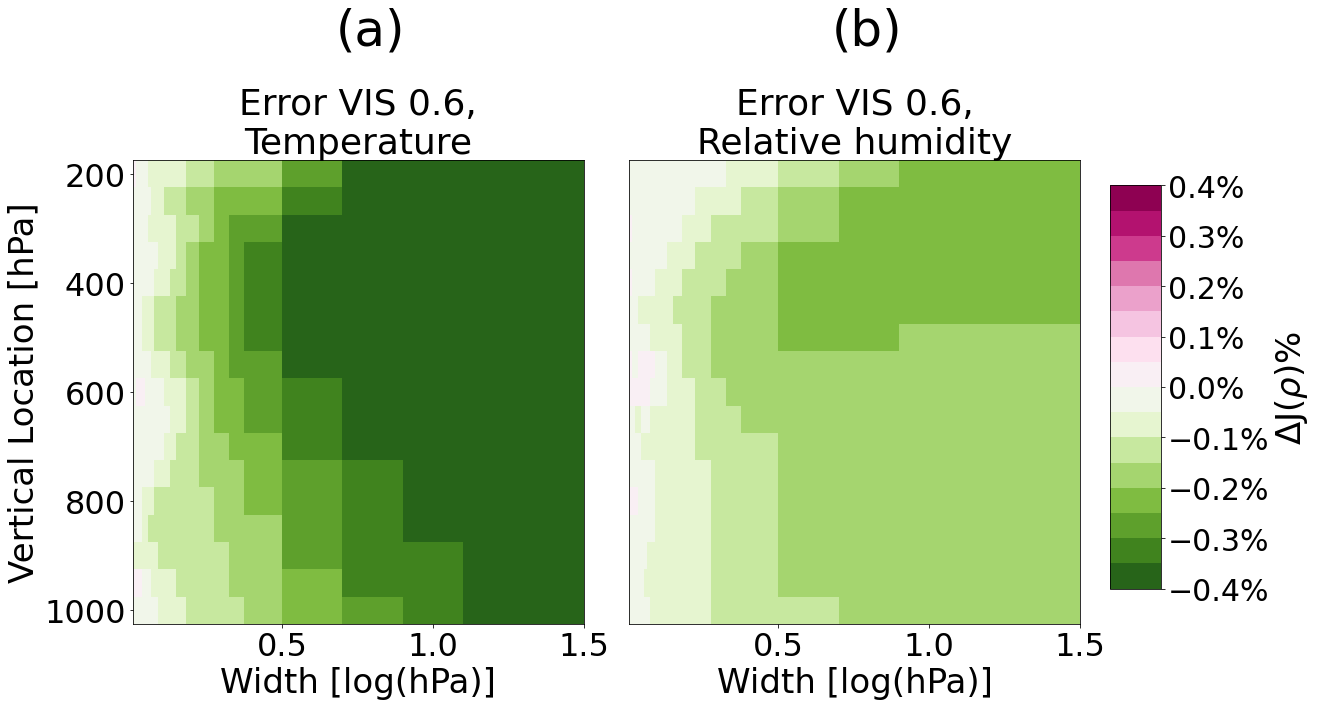

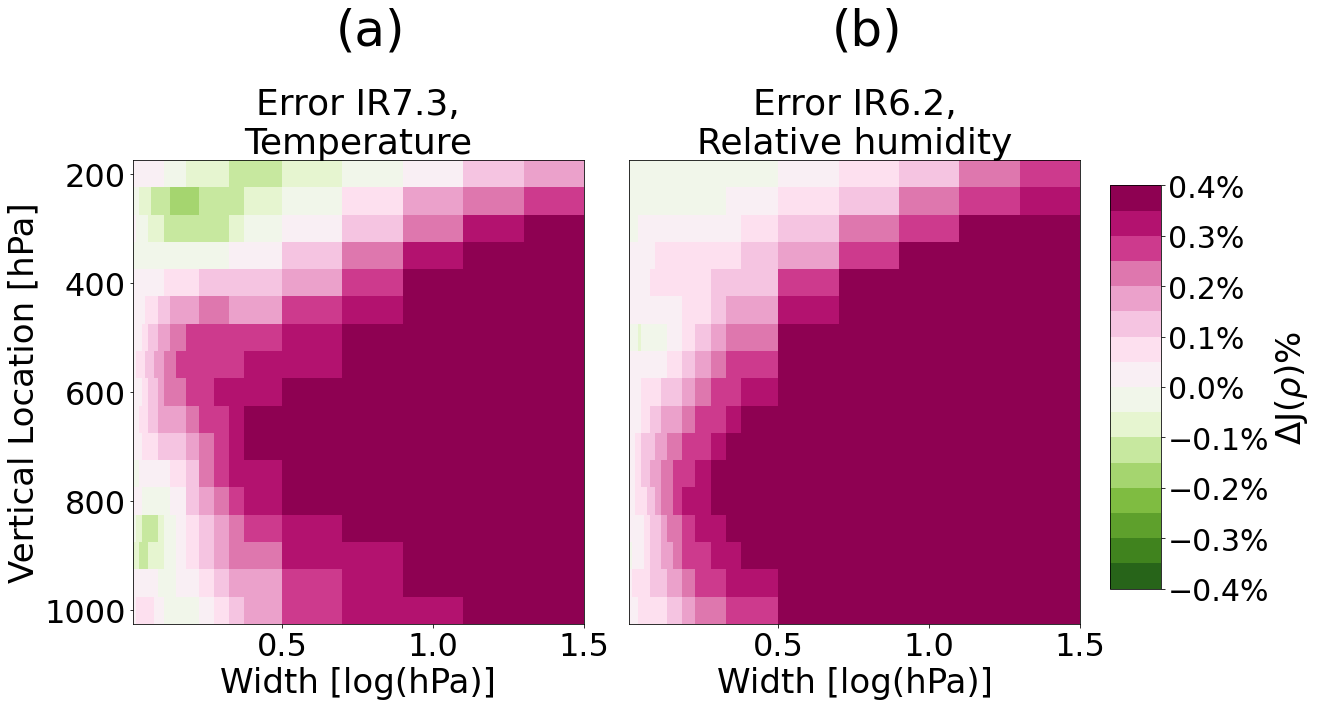

In [85]:
%matplotlib inline
plot_two_row(Global_Errs2[3, :, :], Global_Errs2[2, :, :], 'T_RH_VIS_paper', 
                 obspres_list, vloc_list, cat_1_name = ' VIS 0.6,\nTemperature', cat_2_name = ' VIS 0.6,\nRelative humidity',
                 use_no_obs_err = True, no_obs_err1 = no_obs_err_total2[1], no_obs_err2=no_obs_err_total2[0])
plot_two_row(Global_Errs1[3, :, :], Global_Errs0[2, :, :], 'T_RH_IR_paper', 
                 obspres_list, vloc_list, cat_1_name = ' IR7.3,\nTemperature', cat_2_name = ' IR6.2,\nRelative humidity',
                 use_no_obs_err = True, no_obs_err1 = no_obs_err_total1[1], no_obs_err2=no_obs_err_total0[0])

In [ ]:
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 31)]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
end_code = 'REFL_Result_20_04_2024_'
#save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/failures_20_04_2024'
obspres_list = range(20000, 101000, 5000)
vloc_list = np.concatenate([0.01*np.array(range(1, 8)), 0.02*np.array(range(4, 9)), 0.05*np.array(range(4, 8)), 0.05*np.array(range(8, 30, 4))]) #np.concatenate([0.01*np.array(range(1, 10)), 0.05*np.array(range(2, 8)), 0.05*np.array(range(8, 50, 4))])
errors_location = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ndRTPP_Final'
errors_location_no_sat = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ndRTPP_Final_no_sat_errors'
Global_Errs2, Global_Errs_Halfs2, Global_Errs_Clouds2, Global_Errs_Clouds_Halfs2, no_obs_err_total2, no_obs_err_onoff2, no_obs_err_halfs2, no_obs_err_halfs_onoff2 = sort_cloud_on_off2(ana_days, exp_path, 
                                                                                                                                                                                    obspres_list, vloc_list, 
                                                                                                                                                                                    errors_location,  
                                                                                                                                                                                    end_code, 
                                                                                                                                                                                    errors_location_no_sat, 
                                                                                                                                                                                    [], cloudvar = 'REFL', 
                                                                                                                                                                                    threshold = 0.4, optvar = 'REFL')#, above_threshold = False)


In [ ]:
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 31)]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
end_code = 'IR0_Result_20_04_2024_'
#save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/failures_20_04_2024'
obspres_list = range(20000, 101000, 5000)
vloc_list = np.concatenate([0.01*np.array(range(1, 8)), 0.02*np.array(range(4, 9)), 0.05*np.array(range(4, 8)), 0.05*np.array(range(8, 30, 4))]) #np.concatenate([0.01*np.array(range(1, 10)), 0.05*np.array(range(2, 8)), 0.05*np.array(range(8, 50, 4))])
errors_location = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/No_RTPP_'
errors_location_no_sat = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/No_RTPP_Final_no_sat_errors_IR0_'
Global_Errs0, Global_Errs_Halfs0, Global_Errs_Clouds0, Global_Errs_Clouds_Halfs0, no_obs_err_total0, no_obs_err_onoff0, no_obs_err_halfs0, no_obs_err_halfs_onoff0 = sort_cloud_on_off2(ana_days, exp_path, 
                                                                                                                                                                                    obspres_list, vloc_list, 
                                                                                                                                                                                    errors_location,  
                                                                                                                                                                                    end_code, 
                                                                                                                                                                                    errors_location_no_sat, 
                                                                                                                                                                                    [], cloudvar = 'RAWBT', 
                                                                                                                                                                                    first_RAWBT = True, threshold = 234)


In [ ]:
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 31)]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
end_code = 'IR1_Result_20_04_2024_'
#save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/failures_20_04_2024'
obspres_list = range(20000, 101000, 5000)
vloc_list = np.concatenate([0.01*np.array(range(1, 8)), 0.02*np.array(range(4, 9)), 0.05*np.array(range(4, 8)), 0.05*np.array(range(8, 30, 4))]) #np.concatenate([0.01*np.array(range(1, 10)), 0.05*np.array(range(2, 8)), 0.05*np.array(range(8, 50, 4))])
errors_location = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/No_RTPP_'
errors_location_no_sat = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/No_RTPP_Final_no_sat_errors_IR1_'
Global_Errs1, Global_Errs_Halfs1, Global_Errs_Clouds1, Global_Errs_Clouds_Halfs1, no_obs_err_total1, no_obs_err_onoff1, no_obs_err_halfs1, no_obs_err_halfs_onoff1 = sort_cloud_on_off2(ana_days, exp_path, 
                                                                                                                                                                                    obspres_list, vloc_list, 
                                                                                                                                                                                    errors_location,  
                                                                                                                                                                                    end_code, 
                                                                                                                                                                                    errors_location_no_sat, 
                                                                                                                                                                                    [], cloudvar = 'RAWBT', 
                                                                                                                                                                                    first_RAWBT = False, threshold = 251)


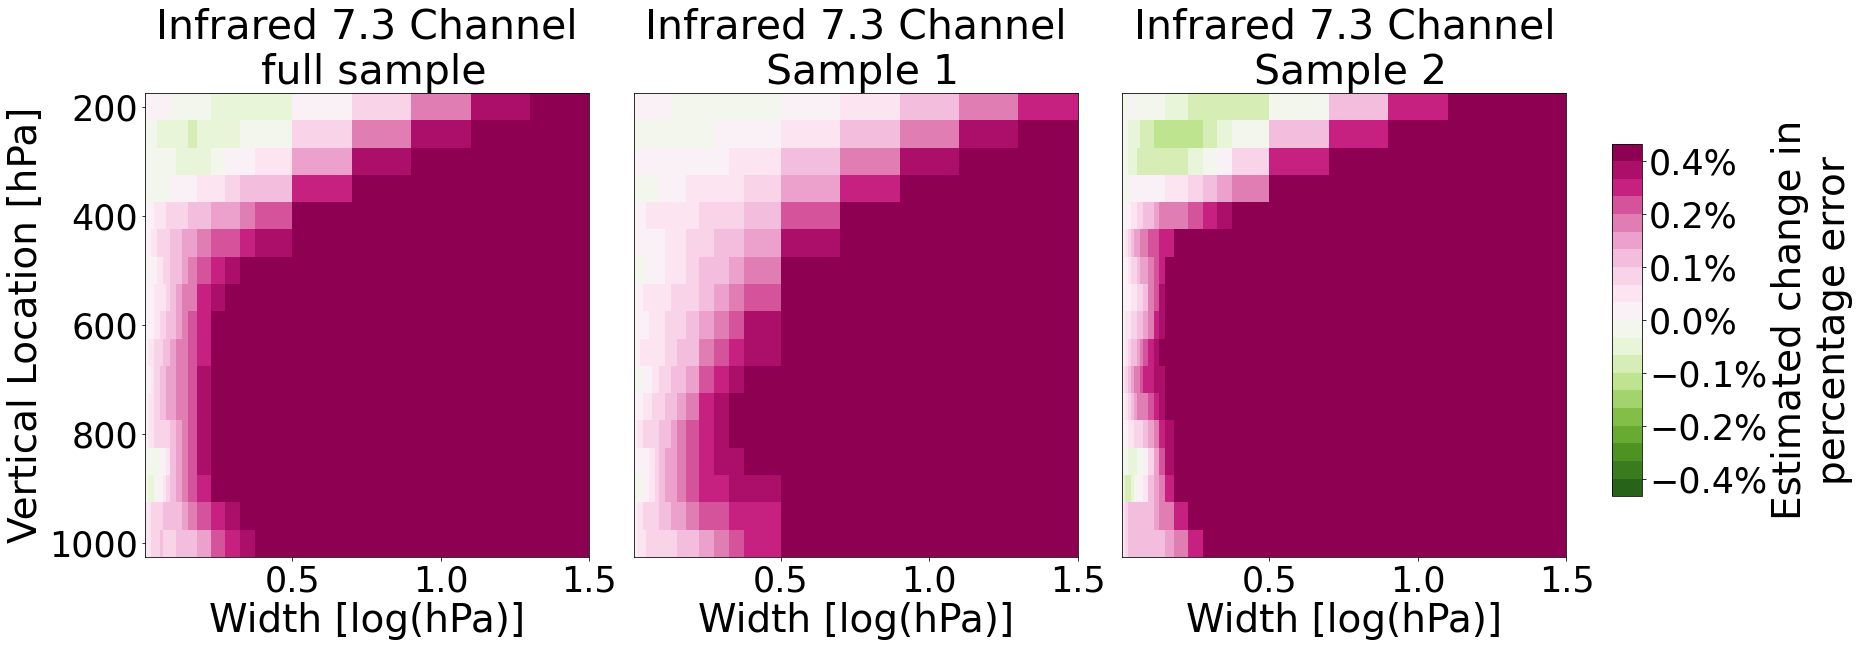

In [56]:
G_errs_test, G_errs_halfs_test, G_errs_clouds_test, G_errs_clouds_halfs_test, G_errs_no_obs_test, G_errs_no_obs_halfs_test, G_errs_no_obs_clouds_test, G_errs_no_obs_clouds_halfs_test =  global_from_T_RH(Global_Errs1, 
                                                                                                                                                                                                            Global_Errs_Halfs1, 
                                                                                                                                                                                                            Global_Errs_Clouds1, 
                                                                                                                                                                                                            Global_Errs_Clouds_Halfs1, 
                                                                                                                                                                                                            no_obs_err_total1, 
                                                                                                                                                                                                            no_obs_err_halfs1, 
                                                                                                                                                                                                            no_obs_err_onoff1, 
                                                                                                                                                                                                            no_obs_err_halfs_onoff1,
                                                                                                                                                                                                            just_T = False)

plot_sensitivity_cloud_contour_together(G_errs_test, G_errs_halfs_test, G_errs_halfs_test, G_errs_clouds_halfs_test,
                                'New_IR1_resampling', obspres_list, vloc_list,  use_no_obs_err = True, 
                                no_obs_err = G_errs_no_obs_test, no_obs_err_half = G_errs_no_obs_halfs_test, 
                                no_obs_err_clouds = G_errs_no_obs_halfs_test, 
                                no_obs_err_clouds_halfs = G_errs_no_obs_clouds_halfs_test, 
                                cat_1_name = ' Sample 1', cat_2_name = ' Sample 2', 
                                half_1_name=' Sample 1', half_2_name = ' Sample 2', 
                                Title = 'Infrared 7.3 Channel\n', save = True)